# Image Caption Generator

Image caption generator is a model which generates a caption that describes the contents of the image. It requires both methods from computer vision to understand the content of the image and a language model from NLP
to translate the understanding of the image into words.


Deep Learning Models have provided a way to get excellent way to get results for examples of this problem.

## Introduction

In this project the features of the image is extracted using a pre-trained CNN model and is fed into a LSTM model along with captions to train. The trained model will be able to generate captions for an image fed into it.

## Dataset

The dataset used is Flickr-8k which consists of 8091 images with 5 captions per image.

### Mounting the drive where the dataset is present.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing the required libraries

In [0]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")

### Loading the images and its respective captions.

In [5]:
dir_flickr_text = "/content/drive/My Drive/Colab Notebooks/Image/Dataset/Flickr8k_text/Flickr8k.token.txt"
dir_flickr_images = "/content/drive/My Drive/Colab Notebooks/Image/Dataset/Flicker8k_Dataset"

jpgs = os.listdir(dir_flickr_images)
print("Number of jpgs : ", len(jpgs))

Number of jpgs :  8170


In [6]:
f_txt = open(dir_flickr_text,'r')
text = f_txt.read()
f_txt.close()

data_txt = []
for line in text.split('\n'):
  col = line.split('\t')
  if len(col) == 1:
    continue
  ind = col[0].split('#')
  data_txt.append(ind + [col[1].lower()])
print(data_txt[0:5])

df_flickr_txt = pd.DataFrame(data_txt, columns = ["filename","index","caption"])
print(df_flickr_txt.head(), "Number of captions",len(df_flickr_txt.index)//5)


unique_filenames = np.unique(df_flickr_txt.filename.values)
print("Number of unique images ", len(unique_filenames))

[['1000268201_693b08cb0e.jpg', '0', 'a child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', '1', 'a girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', '2', 'a little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', '3', 'a little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', '4', 'a little girl in a pink dress going into a wooden cabin .']]
                    filename  ...                                            caption
0  1000268201_693b08cb0e.jpg  ...  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg  ...              a girl going into a wooden building .
2  1000268201_693b08cb0e.jpg  ...   a little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  ...  a little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  ...  a little girl in a pink dress going into a woo...

[5 rows x 3 columns] N

In [0]:
from os.path import isfile, join
onlyfiles = [f for f in os.listdir(dir_flickr_images) if isfile(join(dir_flickr_images, f))]

### Having a look at some of the images and their captions.

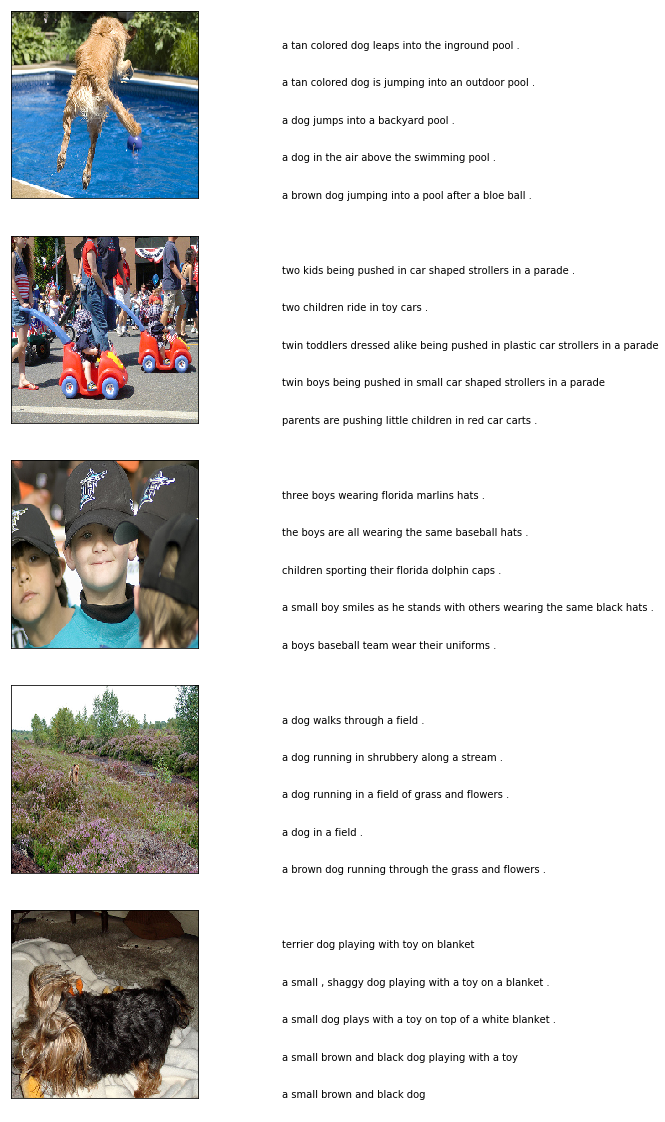

In [8]:
from keras.preprocessing.image import load_img, img_to_array

num_pics = 5
num_pix = 224
target_size = (num_pix,num_pix,3)

c = 1
fig = plt.figure(figsize=(10,20))
for jpgs in unique_filenames[160:165]: # random 5 images chosen 
  filename = dir_flickr_images + '/' + jpgs
  captions = list(df_flickr_txt["caption"].loc[df_flickr_txt["filename"] == jpgs].values)
  image_load = load_img(filename, target_size=target_size)
  
  #Loading images
  ax = fig.add_subplot(num_pics,2,c,xticks=[],yticks=[])
  ax.imshow(image_load)
  c += 1
  
  #Loading corresponding captions for the image  
  ax = fig.add_subplot(num_pics,2,c)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  for i, caption in enumerate(captions):
      ax.text(0,i,caption,fontsize=10)
  c += 1
plt.show() 

## Data Preparation

Both images and captions needs to be prepared before feeding into RNN model.

## Text preparation

Captions need to be cleaned before further analysis as uncleaned data will not generate good captions. Functions have been created to remove punctuation, numerics and single characters.

In [0]:
#Cleaning up the inputs
import string
def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  new_text = text.translate(translator)
  return(new_text)
  
def remove_single_char(text):
  text_len_more_1 = ""
  for i in text.split():
    if len(i) > 1:
      text_len_more_1 += " " + i 
  return(text_len_more_1)

def remove_numeric(text):
  text_no_num = ""
  for i in text.split():
    if i.isalpha():
      text_no_num += " " + i
  return(text_no_num)

### Calling the function to clean the captions




In [10]:
for i, caption in enumerate(df_flickr_txt.caption.values):
  newtext = remove_punctuation(caption)
  newtext = remove_single_char(newtext)
  newtext = remove_numeric(newtext)
  
  df_flickr_txt["caption"].iloc[i] = newtext
print("Captions cleaned")

Captions cleaned


### Adding start and end sequence tokens.

These tokens are added for easy identification of start and end of the caption. These are necessary as captions are of variable length.

In [11]:
from copy import copy

def add_start_end_sequence(text):
  captions = []
  for txt in text:
    txt = "startseq " + txt + " endseq"
    captions.append(txt)
  return(captions)

df_txt = copy(df_flickr_txt)
df_txt["caption"] = add_start_end_sequence(df_flickr_txt["caption"])
print(df_txt.head(5))
del df_flickr_txt

                    filename  ...                                            caption
0  1000268201_693b08cb0e.jpg  ...  startseq  child in pink dress is climbing up s...
1  1000268201_693b08cb0e.jpg  ...   startseq  girl going into wooden building endseq
2  1000268201_693b08cb0e.jpg  ...  startseq  little girl climbing into wooden pla...
3  1000268201_693b08cb0e.jpg  ...  startseq  little girl climbing the stairs to h...
4  1000268201_693b08cb0e.jpg  ...  startseq  little girl in pink dress going into...

[5 rows x 3 columns]


## Image Preparation

Image features will be extracted using VGG16's pre trained networks

### Downloading the pre-trained weights of VGG-16

In [39]:
from keras.applications import VGG16

vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
vgg.summary()

W0830 16:36:34.359970 139635706197888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 61s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

### Removing the last layer of VGG16

The last layer of the VGG 16 model is removed as we are using it to extract features of image rather than for object classification

In [40]:
from keras.models import Sequential, Model

vgg.layers.pop()
vgg = Model(inputs=vgg.input, outputs=vgg.layers[-1].output)
vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Feature Extraction

The images are preprocessed and the features are stored in an OrderedDict.

In [0]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
count = 0
for i, name in enumerate(jpgs):
  file_path = dir_flickr_images + "/" + name
  image = load_img(file_path, target_size=(224,224,3))
  image = img_to_array(image)
  image = preprocess_input(image)  
  y_pred = vgg.predict(image.reshape( (1,) + image.shape[:3]))
  count += 1
  if count%100 == 0: 
    print(count)
  
  images[name] = y_pred.flatten()

### Saving the extracted features as numpy arrays in a file

In [0]:
np.save("/content/drive/My Drive/Colab Notebooks/Image/Assets/pred.npy", y_pred)

In [0]:
np.save("/content/drive/My Drive/Colab Notebooks/Image/Assets/Image_feature.npy", images)

### Loading the extracted features from the file.

In [0]:
y_pred = np.load("/content/drive/My Drive/Colab Notebooks/Image/Assets/pred.npy")

In [0]:
# Faced a bug, added code to solve it (allowed pickle)
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
images = np.load("/content/drive/My Drive/Colab Notebooks/Image/Assets/Image_feature.npy")
np.load = np_load_old


### A look at the features extracted

In [14]:
jpg = '377872472_35805fc143.jpg'
print(images.flat[0][jpg])


[0.         0.         8.027181   ... 0.42955977 7.4182315  0.        ]


### Linking the image and caption data

This dataset has 5 captions per image. For simplicity, I am using only 1 caption per image. 

In [15]:
n_images, indexes = [], []
df_txt0 = df_txt.loc[df_txt["index"].values == "0", :]
for i, jpg in enumerate(df_txt0.filename):
  if jpg in images.item().keys():
    n_images.append(images.flat[0][jpg])
    indexes.append(i)
    
filename = df_txt0["filename"].iloc[indexes].values
n_captions = df_txt0["caption"].iloc[indexes].values
n_images = np.array(n_images)
print(n_images.shape) #(8091,4096) 8091 images with 4096 features per image

(8091, 4096)


### Tokenizing the Captions

Converting into char vector to integer vector.

In [16]:
from keras.preprocessing.text import Tokenizer

num_word = 7000
tokenizer = Tokenizer(num_words = num_word)
tokenizer.fit_on_texts(n_captions)
print("Voabulary Size : {}".format(len(tokenizer.word_index) + 1))

data_txt = tokenizer.texts_to_sequences(n_captions)
print(data_txt[:10])

Voabulary Size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2], [1, 38, 32, 6, 214, 504, 2], [1, 12, 5, 14, 8, 7, 33, 3, 148, 695, 271, 46, 14, 186, 2], [1, 8, 652, 69, 163, 70, 4, 359, 22, 36, 79, 18, 130, 2], [1, 13, 245, 3, 41, 9, 1385, 114, 3, 160, 2], [1, 12, 8, 239, 42, 552, 2]]


### Splitting the Dataset into Training, Testing and Validation Set

In [0]:
def split_data(data, num_test, num_val):
  return(data[:num_test], data[num_test:num_test+num_val], data[num_test+num_val:])

In [0]:
ratio_test, ratio_val = 0.2, 0.2
N = len(data_txt)
num_test, num_val = int(N * ratio_test), int(N * ratio_val)

dcap_test, dcap_val, dcap_train = split_data(data_txt, num_test, num_val)
di_test, di_val, di_train = split_data(n_images, num_test, num_val)
file_test, file_val, file_train = split_data(filename, num_test, num_val)

### Maximum Length of a caption and size of vocabulary.

In [20]:
maxlen = np.max([len(x) for x in data_txt])
vocab_size = len(tokenizer.word_index) + 1

print(maxlen, vocab_size)

30 4476


### Final Preprocessing

Final preprocessing so that data can be used as input and output in a Keras model. We are creating padded sequences (for variable length) and next words (for LSTM model).

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


def final_preprocess(n_images, data_txt):
  
  n = len(data_txt)
  
  Xtext, Ximage, ytext = [],[],[]
  for txt, image in zip(data_txt, n_images):
    for i in range(1,len(txt)):
      partial_seq, next_words = txt[:i],txt[i]
      partial_seq = pad_sequences([partial_seq], maxlen=maxlen).flatten()
      next_words = to_categorical(next_words, num_classes = vocab_size)
      
      Xtext.append(partial_seq)
      Ximage.append(image)
      ytext.append(next_words)
      
  Xtext  = np.array(Xtext)
  Ximage = np.array(Ximage)
  ytext  = np.array(ytext)
  print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
  return(Xtext,Ximage,ytext)


### A look at the shapes of the training and validation data

In [22]:
Xtext_train, Ximage_train, ytext_train = final_preprocess(di_train, dcap_train)
Xtext_val,   Ximage_val,   ytext_val = final_preprocess(di_val, dcap_val)

 (49631, 30) (49631, 4096) (49631, 4476)
 (16353, 30) (16353, 4096) (16353, 4476)


## Model

This model takes two inputs:

4096-dimensional image features from pre-trained VGG model

1.   4096-dimensional image features from pre-trained VGG model
2. tokenized captions up to (t)th word. 

The single output is:  tokenized (t+1)th word of caption

**Prediction**

Given the caption prediction up to the (t)th word, the model can predict the (t+1)th word in the caption, and then the input caption can be augmented with the predicted word to contain the caption up to the (t+1)th word. The augmented caption up to the (t+1)th word can, in turn, be used as input to predict the (t+2) word.
The process is repeated until the **"endseq"** is encountered


In [23]:
from keras.layers import Input, Dense, Embedding, LSTM, Add

dim_embedding = 64

input_image = Input(shape = (Ximage_train.shape[1],))
fimage = Dense(256, activation="relu", name="ImageFeature")(input_image)

input_txt = Input(shape=(maxlen,))
ftxt = Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = LSTM(256,name="CaptionFeature")(ftxt)

#Combining both image and text layer
decoder = Add()([ftxt,fimage])
decoder = Dense(256,activation='relu')(decoder)
output = Dense(vocab_size,activation='softmax')(decoder) # Returns probability of t+1 word
model = Model(input = [input_image, input_txt], output = output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

W0830 15:37:21.809556 139635706197888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 15:37:21.835738 139635706197888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 15:37:21.841755 139635706197888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 15:37:22.237066 139635706197888 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3239: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       286464      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding_1[0][0]                
____________________________________________________________________________________________

### Training the model 

In [24]:
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

W0830 15:37:35.916873 139635706197888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 49631 samples, validate on 16353 samples
Epoch 1/5
 - 91s - loss: 5.3077 - acc: 0.1615 - val_loss: 4.7456 - val_acc: 0.2178
Epoch 2/5
 - 85s - loss: 4.3457 - acc: 0.2391 - val_loss: 4.4535 - val_acc: 0.2629
Epoch 3/5
 - 85s - loss: 3.8957 - acc: 0.2716 - val_loss: 4.3674 - val_acc: 0.2766
Epoch 4/5
 - 85s - loss: 3.5800 - acc: 0.2929 - val_loss: 4.3485 - val_acc: 0.2806
Epoch 5/5
 - 85s - loss: 3.3130 - acc: 0.3090 - val_loss: 4.3758 - val_acc: 0.2862
TIME TOOK 7.22MIN


### Saving the model weights

In [0]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/Image/Saved_models/image_caption.h5")

### Saving model as json file

In [0]:
from keras.models import model_from_json
model_json = model.to_json()

with open("/content/drive/My Drive/Colab Notebooks/Image/Saved_models/model.json", "w+") as json_file:
    json_file.write(model_json)


### Plotting the loss and val_loss curves

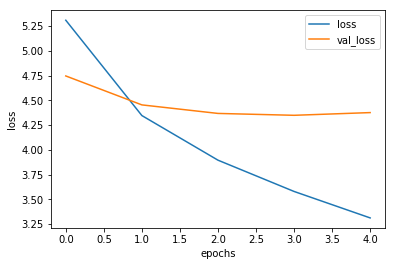

In [25]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**We can clearly see that the model is overfitting the data. This is beacuse of the small size of the data used.**

In [0]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

### Predicting the captions of the images in the Training set.

In [0]:
def predict_captions(image):
  inp_txt = "startseq"
  
  for word in range(maxlen):
    sequence = tokenizer.texts_to_sequences([inp_txt])[0]
    sequence = pad_sequences([sequence], maxlen)
    y_out = model.predict([image,sequence], verbose = 0)
    y_out = np.argmax(y_out)
    new_word = index_word[y_out]
    inp_txt += " " + new_word
    if new_word == "endseq":
      break
  return(inp_txt)

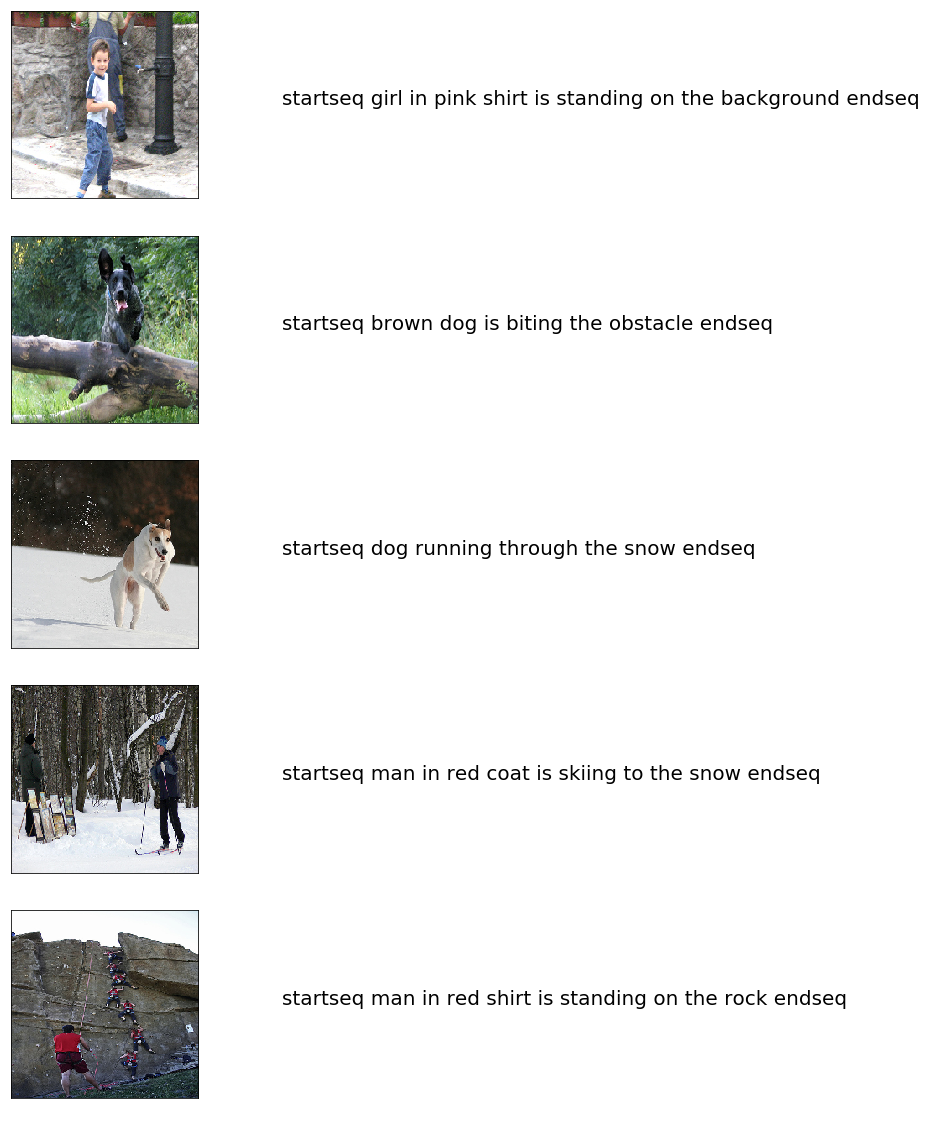

In [28]:
n_pic = 5
target_size = (224,224,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgs, im_feature in zip(file_test[8:13],di_test[8:13]):
  filename = dir_flickr_images + '/' + jpgs
  image_load = load_img(filename, target_size=target_size)
  ax = fig.add_subplot(n_pic,2,count,xticks=[],yticks=[])
  ax.imshow(image_load)
  count += 1
  
  caption = predict_captions(im_feature.reshape(1,len(im_feature)))
  ax = fig.add_subplot(n_pic,2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
  ax.text(0,0.5,caption,fontsize=20)
  count += 1
  
plt.show()

## Evaluating the model performance

Traditional accuracy model cannot be used to evaluate the performance of the prediction model. We use a special metric for text evaluation known as [BLEU score](https://en.wikipedia.org/wiki/BLEU). 

### Separating images with high and low bleu score.

In [29]:
from nltk.translate.bleu_score import sentence_bleu

nkeep= 5
pred_good, pred_bad, bleu_scores = [], [], []
c = 0
for jpg, image_feature, token_txt in zip(file_test, di_test, dcap_test):
  c += 1
  if c%200 == 0:
    print(c)
  caption_ref = [index_word[i] for i in token_txt]
  caption_ref = caption_ref[1:-1]
  
  caption = predict_captions(image_feature.reshape(1, len(image_feature)))
  caption = caption.split()
  caption = caption[1:-1]
  
  bleu = sentence_bleu([caption_ref], caption)
  bleu_scores.append(bleu)
  
  if bleu > 0.7 and len(pred_good) < nkeep:
    pred_good.append((bleu, jpg, caption_ref, caption))
  elif bleu < 0.3 and len(pred_bad) < nkeep:
    pred_bad.append((bleu, jpg, caption_ref, caption))
  

200
400
600
800
1000
1200
1400
1600


In [41]:
print(bleu_scores)
print("Mean score ", np.mean(bleu_scores))

[0.4482700320176827, 0.7598356856515925, 0.43092381945890607, 0.5166357204442371, 0.408248290463863, 0, 0.46548383647045716, 0.4919625503668659, 0.5773502691896257, 0.6389431042462724, 0.31772355751081427, 0.3478700554542394, 0, 0.41746352657471425, 0.46230595512422085, 0.2842202242491899, 0.4630777161991027, 0.19303951204286907, 0.5623413251903491, 0.7598356856515925, 0.25307989573458556, 0.5773502691896257, 0.256976373216606, 0.7400828044922853, 0.2286835008591421, 0.6529942057256104, 0.29642151188002913, 0.45180100180492244, 0.5773502691896257, 0.7071067811865476, 0.5081327481546147, 0.3746792881553041, 0.38875142041440197, 0.3478700554542394, 0, 0.6094445482670285, 0.41368954504257255, 0.4671379777282001, 0.7400828044922853, 0, 0.5491004867761125, 0.43012508513132625, 0.6143868746168435, 0, 0.26782849591300867, 0.35733817274964674, 0, 0.5623413251903491, 0.48549177170732344, 0.35733817274964674, 0.21461525035625467, 0.3665113625996641, 0.730633242658635, 0.3155984539112945, 0.54910

### Plotting images with their bleu scores

Checking the quality of captions generated.

In [0]:
def create_str(caption_true):
  strue = ""
  for s in caption_true:
    strue += " " + s
  return(strue)


def plot_images(pred_data):
  target_size = (224,224,3)    
  count = 1
  fig = plt.figure(figsize=(10,20))
  
  n_pic = len(pred_data)
  for pd in pred_data:
    bleu, jpg, caption_ref, caption = pd
    filename = dir_flickr_images + '/' + jpg
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(n_pic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    caption_ref = create_str(caption_ref)
    caption = create_str(caption)
    
    
    ax = fig.add_subplot(n_pic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.7,"true:" + caption_ref,fontsize=20)
    ax.text(0,0.4,"pred:" + caption,fontsize=20)
    ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
    count += 1
plt.show()

### Images with high BLEU score

High Bleu score


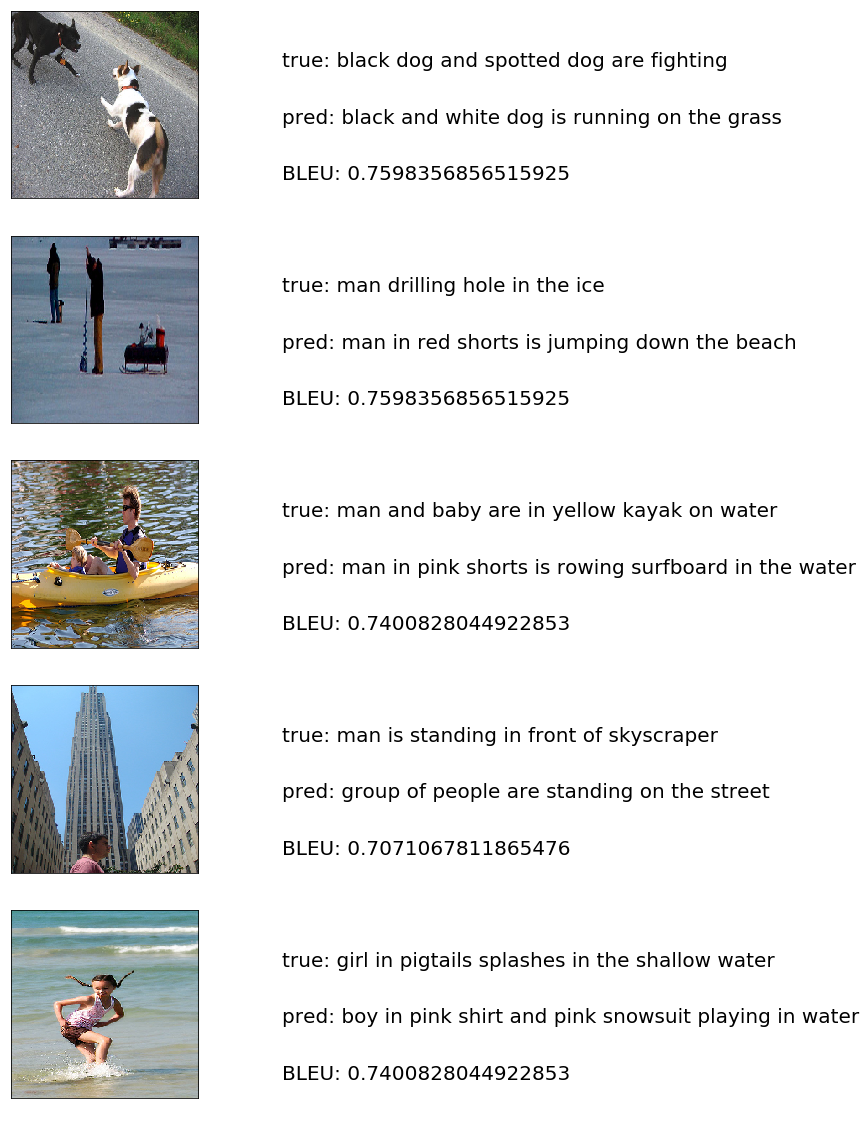

In [42]:
print("High Bleu score")
plot_images(pred_good)


### Images with Low BLEU score

Bad Caption


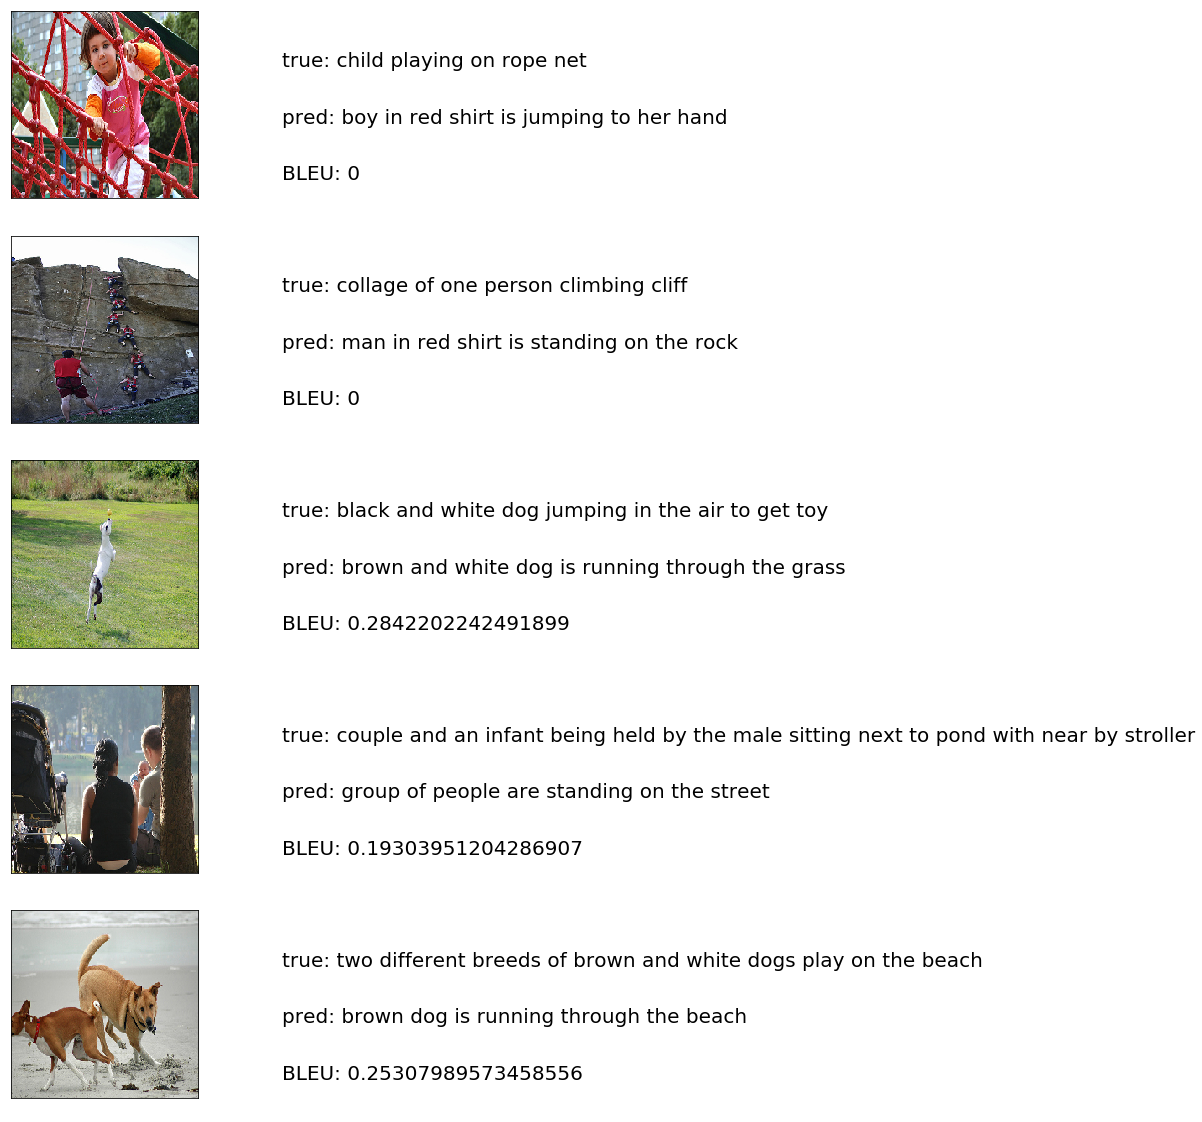

In [38]:
print("Low Bleu Score")
plot_images(pred_bad)


### **In the images with low bleu score we observe that the captions still gives a very good idea of what is happening in the image. The low bleu score is due to the predicted text not matching the reference text.**

# Conclusion

The model has been successfully trained to generate the captions as expected for the images. The caption generator can further be improved by doing the following steps:



1.   Using a bigger dataset like Flickr-30k
2.   Tuning the hyper parameters of the model.
3.   Using more deeper models.

